# Battle of Neighborhoods of London and NYC

###### screenshots for maps are attached in the  github repository

In [308]:
# importing all the required libraries

import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import requests
from geopy.geocoders import Nominatim
import geocoder
import folium
from os import path
# import k-means from clustering stage
from sklearn.cluster import KMeans
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.cm as cm
import matplotlib.colors as colors
% matplotlib inline

### London Neighborhood data from Wikipedia

In [309]:
london_neighborhoods = pd.read_csv("London_neighborhoods.csv")

In [310]:
london_neighborhoods.head()

Location                            borough            town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode_district Dial_code OS_grid_ref  
0               SE2        20    TQ465785  
1            W3, W4        20    TQ205805  
2               CR0        20    TQ375645  
3               CR0        20    TQ345665  
4         DA5, DA14        20    TQ478728

In [311]:
#check the shape of our dataset before cleaning
london_neighborhoods.shape

(537, 6)

#### Data Cleaning of London Neighborhoods

In [312]:
#dropping the extra columns of Dial_code and OS_grid_ref

london_neighborhoods= london_neighborhoods.drop("Dial_code", axis=1)
london_neighborhoods = london_neighborhoods.drop("OS_grid_ref",axis=1)
london_neighborhoods.head()

Location                            borough            town  \
0   Abbey Wood              Bexley, Greenwich [7]          LONDON   
1        Acton  Ealing, Hammersmith and Fulham[8]          LONDON   
2    Addington                         Croydon[8]         CROYDON   
3   Addiscombe                         Croydon[8]         CROYDON   
4  Albany Park                             Bexley  BEXLEY, SIDCUP   

  Postcode_district  
0               SE2  
1            W3, W4  
2               CR0  
3               CR0  
4         DA5, DA14

In [313]:
# renaming the columns

cols = ["Neighborhoods","Borough","Town","Postcode"]
london_neighborhoods.columns = cols

london_neighborhoods.head()

Neighborhoods                            Borough            Town   Postcode
0    Abbey Wood              Bexley, Greenwich [7]          LONDON        SE2
1         Acton  Ealing, Hammersmith and Fulham[8]          LONDON     W3, W4
2     Addington                         Croydon[8]         CROYDON        CR0
3    Addiscombe                         Croydon[8]         CROYDON        CR0
4   Albany Park                             Bexley  BEXLEY, SIDCUP  DA5, DA14

In [314]:
# counting the town whcih comes under london city
london_neighborhoods[london_neighborhoods.Town == "LONDON"].shape

(299, 4)

In [315]:
# sclicing the town to just london
london_neighborhoods = london_neighborhoods[london_neighborhoods.Town == "LONDON"]

In [316]:
london_neighborhoods[london_neighborhoods.Town == "LONDON"].head()

Neighborhoods                            Borough    Town Postcode
0    Abbey Wood              Bexley, Greenwich [7]  LONDON      SE2
1         Acton  Ealing, Hammersmith and Fulham[8]  LONDON   W3, W4
6       Aldgate                           City[10]  LONDON      EC3
7       Aldwych                    Westminster[10]  LONDON      WC2
9       Anerley                        Bromley[11]  LONDON     SE20

In [317]:
# now since the whole "Town" column is from london we dont need that column for analysis
# dropping the Town column

london_neighborhoods = london_neighborhoods.drop("Town",axis=1)
london_neighborhoods.head()

Neighborhoods                            Borough Postcode
0    Abbey Wood              Bexley, Greenwich [7]      SE2
1         Acton  Ealing, Hammersmith and Fulham[8]   W3, W4
6       Aldgate                           City[10]      EC3
7       Aldwych                    Westminster[10]      WC2
9       Anerley                        Bromley[11]     SE20

In [318]:
# check for NULL vales 
london_neighborhoods.isna().sum()

Neighborhoods    0
Borough          0
Postcode         0
dtype: int64

#### No NULL values we are good for analysis

In [319]:
# checking if the postcode is unique for all teh rows
print("Normal Non Unique shape of dataframe : ",london_neighborhoods.Postcode.shape)

print("Unique shape of Postcodes in dataframe : ",london_neighborhoods.Postcode.unique().shape)


Normal Non Unique shape of dataframe :  (299,)
Unique shape of Postcodes in dataframe :  (151,)


##### We see that we have 151 unique postal code and currently we have 299 neighborhoods 
#### So, grouping neighborhoods fro every unique postal code 

In [320]:
london_neighborhoods = london_neighborhoods.groupby(['Postcode','Borough'])['Neighborhoods'].apply(lambda x: ','.join(x.unique())).reset_index()

In [321]:
london_neighborhoods.head()

Postcode         Borough                                      Neighborhoods
0       DA5        Dartford                                           Dartford
1        E1   Tower Hamlets  Mile End,Ratcliff,Shadwell,Spitalfields,Stepne...
2       E10         Hackney                                         Lea Bridge
3  E10, E15  Waltham Forest                                             Leyton
4       E11       Redbridge                                           Wanstead

In [322]:
london_neighborhoods.shape

(208, 3)

We have 208 unique combinations of lodon Postcode and Borough.

Now next thing is getting the neighborhood lattitude and longitude coordinates.

In [323]:
# defining the function for geopy library to get latitude and longitude for all the neighborhoods

def getNeighborhoodLatLong(Postcode,Borough,Neighborhoods):
    
    #Neighborhood with lat , long
    latlang = []
    # defining the user agent for geopy
    geolocator = Nominatim(user_agent="london_neighborhoods")
    
    # for every unique combination of Neighborhood and Borough get the lattitude and longitude
    for postcode, borough, neigh in zip(Postcode,Borough,Neighborhoods):
        address = str(postcode +"London, United Kingdom")
        location = geocoder.arcgis(address)
        latlang.append(
        location.latlng
        )
    
    return(latlang)


In [324]:
london_neigh = getNeighborhoodLatLong( Postcode = london_neighborhoods["Postcode"],
                                      Borough = london_neighborhoods["Borough"],
                                      Neighborhoods = london_neighborhoods["Neighborhoods"]
)

In [325]:
len(london_neigh)

208

In [326]:
london_neigh[:5]

[[53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [53.40838660500003, -1.9695595439999352],
 [51.558850000000064, -0.00732999999996764],
 [53.40838660500003, -1.9695595439999352]]

In [327]:
# we got the latitide and longitude for each of the postal code now lets merge it to our neighborhoods

# since our cordinates are combines lets split them into two lists of latitude and longitude.
latitude= []
longitude = []
for lat, lng in london_neigh:
    latitude.append(lat)
    longitude.append(lng)

print(latitude[0:5])
print(longitude[0:5])


[53.40838660500003, 53.40838660500003, 53.40838660500003, 51.558850000000064, 53.40838660500003]
[-1.9695595439999352, -1.9695595439999352, -1.9695595439999352, -0.00732999999996764, -1.9695595439999352]


In [328]:
# now that we have got the latitude and logitude lists we can just put them in our dataframe.
london_neighborhoods["Latitude"] = latitude
london_neighborhoods["Longitude"] = longitude

london_neighborhoods.head()

Postcode         Borough  \
0       DA5        Dartford   
1        E1   Tower Hamlets   
2       E10         Hackney   
3  E10, E15  Waltham Forest   
4       E11       Redbridge   

                                       Neighborhoods   Latitude  Longitude  
0                                           Dartford  53.408387   -1.96956  
1  Mile End,Ratcliff,Shadwell,Spitalfields,Stepne...  53.408387   -1.96956  
2                                         Lea Bridge  53.408387   -1.96956  
3                                             Leyton  51.558850   -0.00733  
4                                           Wanstead  53.408387   -1.96956

In [329]:
# now we can plot the neighborhoods on map of london
# but before that we have to get the coordinates of london city! lets do that again using geocoder
address = 'London, United Kingdom'

geolocator = Nominatim(user_agent="london_neighborhoods")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 51.5073219, -0.1276474.


In [330]:
# create map of Lomdon using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10.55)

# add markers to map
for lat, lng, borough, neighborhood in zip(london_neighborhoods['Latitude'], london_neighborhoods['Longitude'], london_neighborhoods['Borough'], london_neighborhoods['Neighborhoods']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
map_london

### Define Foursquare Credentials and Version

In [331]:
CLIENT_ID = '2F0YVH52B53OB0MCMNR3SXCQBRKYNOC3YDJ23NJQXKXY5EFR' # your Foursquare ID
CLIENT_SECRET = 'QLYK2YW4BTWD1PBCWTOIMHNIGL0JC5X14G0APKAR1FR5T4AG' # your Foursquare Secret
VERSION = '20191031' # Foursquare API version taking last month api for analysis

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2F0YVH52B53OB0MCMNR3SXCQBRKYNOC3YDJ23NJQXKXY5EFR
CLIENT_SECRET:QLYK2YW4BTWD1PBCWTOIMHNIGL0JC5X14G0APKAR1FR5T4AG


### Exploring Neighborhoods in London

Lets get the top 100 venues in this area with their categories within 500m radius

In [332]:
LIMIT = 100
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [333]:
london_venues = getNearbyVenues(names=london_neighborhoods['Neighborhoods'],
                                   latitudes=london_neighborhoods['Latitude'],
                                   longitudes=london_neighborhoods['Longitude']
                                  )


Dartford
Mile End,Ratcliff,Shadwell,Spitalfields,Stepney,Wapping,Whitechapel
Lea Bridge
Leyton
Wanstead
Snaresbrook
Leytonstone
Cann Hall
Little Ilford,Manor Park
Plaistow
West Ham
Cubitt Town,Isle of Dogs,Leamouth,Limehouse,Millwall,Poplar
Blackwall
Canary Wharf
Maryland,Stratford
Custom House,North Woolwich,Silvertown
Canning Town
Upper Walthamstow,Walthamstow,Walthamstow Village
South Woodford
Haggerston
Bethnal Green
Cambridge Heath
Old Ford
Bow
Bromley (also Bromley-by-Bow)
Chingford,Highams Park
Lower Clapton,Upper Clapton
Hackney
East Ham
Upton Park
Forest Gate
Dalston,Hackney Central
Shacklewell
Hackney Marshes,Hackney Wick,Homerton,South Hackney
Barbican
Clerkenwell,Finsbury,St Luke's
Farringdon
Angel
Aldgate
Tower Hill
Blackfriars
Temple
Woodford
Hoxton,Shoreditch
De Beauvoir Town,Islington,Pentonville
Barnsbury
Canonbury
Fortis Green
Muswell Hill
Friern Barnet,New Southgate
Brunswick Park
Colney Hatch
Arnos Grove
Bounds Green
North Finchley,Woodside Park
Palmers Green
Osidge

#### Let's check the size of the resulting dataframe


In [334]:
print(london_venues.shape)
london_venues.head()

(1450, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Leyton               51.55885                -0.00733   
1       Leyton               51.55885                -0.00733   
2       Leyton               51.55885                -0.00733   
3       Leyton               51.55885                -0.00733   
4       Leyton               51.55885                -0.00733   

                           Venue  Venue Latitude  Venue Longitude  \
0               Leyton Technical       51.558781        -0.007328   
1                 Deeney's to go       51.561253        -0.009889   
2             Coronation Gardens       51.559517        -0.010643   
3              Oceano Restaurant       51.561250        -0.010059   
4  Leyton Orient Supporters Club       51.559931        -0.013497   

             Venue Category  
0                       Pub  
1            Sandwich Place  
2                      Park  
3  Mediterranean Restaurant  
4                Sports Bar

### Generating a word cloud for getting the most popular venue categories in all the neighborhoods in London.

In [335]:
London_venue_categories = " ".join(venue for venue in london_venues["Venue Category"])
print ("There are {} words in the combination of all review.".format(len(London_venue_categories)))


There are 17860 words in the combination of all review.


In [336]:
#Defiing the function for generating wordcloud
def generate_word_cloud(string):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(string)
    fig= plt.figure(figsize=(16,15))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

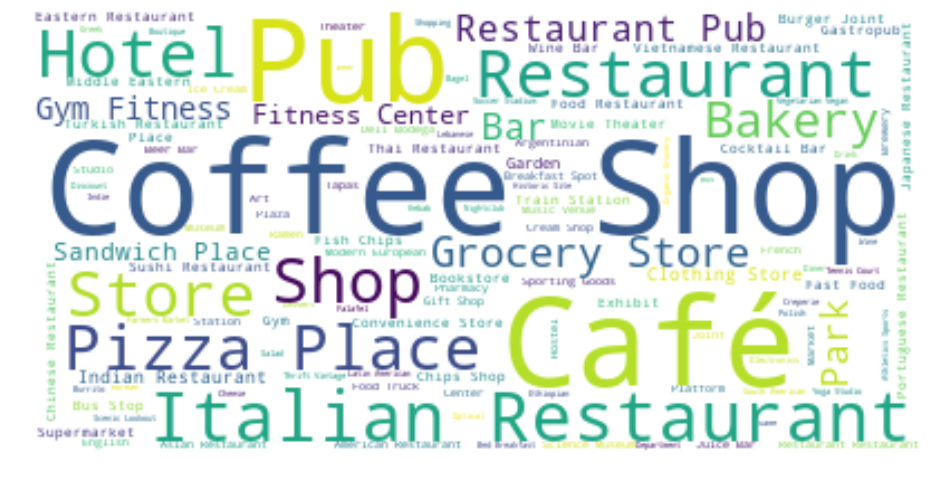

In [337]:
generate_word_cloud(London_venue_categories)

###  From Wordcoud
we can see that Italian Restaurant, CAfe,Pub,Coffee Shop, Stores, Pizaa are most popular venue categories 

#### Checking the size of london_venues we just got values for 43 unique neighborhoods insead of 208 neighborhoods 

In [338]:
london_venues["Neighborhood"].value_counts().count()

43

In [339]:
london_neighborhoods["Neighborhoods"].value_counts().count()

208

So we will just keep data of 43 neighborhoods insted of 208 neighborhoods that we dont have data from foursqure api 

In [340]:
london_neighborhoods = london_neighborhoods.loc[london_neighborhoods["Neighborhoods"].isin(london_venues["Neighborhood"])]
london_neighborhoods["Neighborhoods"].value_counts().count()

43

In [341]:
london_neighborhoods.head()

Postcode         Borough Neighborhoods  Latitude  Longitude
3              E10, E15  Waltham Forest        Leyton  51.55885   -0.00733
10             E13, E15          Newham      West Ham  51.52653    0.02876
27  E5, E8, E9, N1, N16         Hackney       Hackney  51.54505   -0.05532
29              E6, E13          Newham    Upton Park  51.53292    0.05461
32              E8, N16         Hackney   Shacklewell  51.54505   -0.05532

Now for further analysis we just have those neighborhoods which we have some venue data.

Let's check how many venues were returned for each neighborhood

In [342]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                      
Acton                                                         7   
Angel                                                        81   
Arnos Grove                                                   7   
Blackheath Royal Standard                                     2   
Bounds Green                                                  7   
Brent Cross                                                   5   
Brixton                                                      10   
Colney Hatch                                                  7   
Crystal Palace                                               24   
Ealing                                                       85   
Earls Court                                                  59   
Edmonton                                                     13   
Elephant and Castle                                          38   
Finchley                                                     28   
Gipsy Hill                                                   24   
Gospel Oak                                                   49   
Hackney                                                      60   
Harringay                                                    19   
Holborn                                                      71   
Holland Park                                                 78   
Kensal Green                                                  9   
Ladywell                                                     37   
Leyton                                                       40   
Little Venice                                                38   
Neasden                                                       5   
Newington                                                    45   
North Kensington                                             31   
Oval                                                         16   
Primrose Hill                                                53   
Shacklewell                                                  60   
South Kensington                                            100   
South Tottenham,Tottenham,Tottenham Hale                     13   
Southfields                                                  27   
Stamford Hill                                                13   
Stockwell                                                    16   
Sydenham Hill                                                 9   
Temple                                                      100   
Tufnell Park                                                 34   
Tulse Hill                                                   29   
Upton Park                                                   14   
West Ham                                                      6   
Wimbledon                                                    72   
Woodford                                                      9   

                                          Neighborhood Longitude  Venue  \
Neighborhood                                                              
Acton                                                          7      7   
Angel                                                         81     81   
Arnos Grove                                                    7      7   
Blackheath Royal Standard                                      2      2   
Bounds Green                                                   7      7   
Brent Cross                                                    5      5   
Brixton                                                       10     10   
Colney Hatch                                                   7      7   
Crystal Palace                                                24     24   
Ealing                                                        85     85   
Earls Court                                                   59     59   
Edmonton                                           

#### Let's find out how many unique categories can be curated from all the returned venues


In [343]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 217 uniques categories.


## Analyze Each Neighborhood

For analysis using k means clustering we have to convert these venues categories into numerical form using dummies(one hot encoding)

In [344]:
# one hot encoding
london_onehot = pd.get_dummies(london_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues['Neighborhood'] 

london_onehot.head()

African Restaurant  American Restaurant  Antique Shop  \
0                   0                    0             0   
1                   0                    0             0   
2                   0                    0             0   
3                   0                    0             0   
4                   0                    0             0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant      ...       \
0                 0                   0                      0      ...        
1                 0                   0                      0      ...        
2                 0                   0                      0      ...        
3                 0                   0                      0      ...        
4                 0                   0                      0      ...        

   Vegetarian / Vegan Restaurant  Video Game Store  Vietnamese Restaurant  \
0                              0                 0                      0   
1                              0                 0                      0   
2                              0                 0                      0   
3                              0                 0                      0   
4                              0                 0                      0   

   Warehouse Store  Wine Bar  Wine Shop  Wings Joint  Women's Store  \
0                0         0          0            0              0   
1                0         0          0            0              0   
2                0         0          0            0              0   
3                0         0          0            0              0   
4                0         0          0            0              0   

   Yoga Studio  Neighborhood  
0            0        Leyton  
1            0        Leyton  
2            0        Leyton  
3            0        Leyton  
4            0        Leyton  

[5 rows x 218 columns]

In [345]:
london_onehot.shape

(1450, 218)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category


In [346]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

Neighborhood  African Restaurant  \
0                                      Acton            0.000000   
1                                      Angel            0.000000   
2                                Arnos Grove            0.000000   
3                  Blackheath Royal Standard            0.000000   
4                               Bounds Green            0.000000   
5                                Brent Cross            0.000000   
6                                    Brixton            0.000000   
7                               Colney Hatch            0.000000   
8                             Crystal Palace            0.041667   
9                                     Ealing            0.000000   
10                               Earls Court            0.000000   
11                                  Edmonton            0.000000   
12                       Elephant and Castle            0.000000   
13                                  Finchley            0.000000   
14                                Gipsy Hill            0.041667   
15                                Gospel Oak            0.000000   
16                                   Hackney            0.000000   
17                                 Harringay            0.000000   
18                                   Holborn            0.000000   
19                              Holland Park            0.000000   
20                              Kensal Green            0.000000   
21                                  Ladywell            0.000000   
22                                    Leyton            0.000000   
23                             Little Venice            0.000000   
24                                   Neasden            0.000000   
25                                 Newington            0.000000   
26                          North Kensington            0.000000   
27                                      Oval            0.000000   
28                             Primrose Hill            0.000000   
29                               Shacklewell            0.000000   
30                          South Kensington            0.000000   
31  South Tottenham,Tottenham,Tottenham Hale            0.000000   
32                               Southfields            0.000000   
33                             Stamford Hill            0.000000   
34                                 Stockwell            0.000000   
35                             Sydenham Hill            0.000000   
36                                    Temple            0.000000   
37                              Tufnell Park            0.000000   
38                                Tulse Hill            0.000000   
39                                Upton Park            0.000000   
40                                  West Ham            0.000000   
41                                 Wimbledon            0.000000   
42                                  Woodford            0.000000   

    American Restaurant  Antique Shop  Argentinian Restaurant  Art Gallery  \
0              0.000000      0.000000                0.000000     0.000000   
1              0.000000      0.000000                0.000000     0.000000   
2              0.000000      0.000000                0.000000     0.000000   
3              0.000000      0.000000                0.000000     0.000000   
4              0.000000      0.000000                0.000000     0.000000   
5              0.000000      0.000000                0.000000     0.000000   
6              0.000000      0.000000                0.000000     0.000000   
7              0.000000      0.000000                0.000000     0.000000   
8              0.000000      0.000000                0.000000     0.000000   
9              0.000000      0.000000                0.000000     0.000000   
10             0.000000      0.000000                0.000000     0.000000   
11             0.000000      0.000000                0.000000     0.000000   
12             0.000000  

In [347]:
#### Let's confirm the new size
london_grouped.shape

(43, 218)

#### Let's print each neighborhood along with the top 5 most common venues

In [348]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Acton----
               venue  freq
0      Train Station  0.14
1        Gas Station  0.14
2  Indian Restaurant  0.14
3     Breakfast Spot  0.14
4               Park  0.14


----Angel----
                venue  freq
0         Coffee Shop  0.09
1                 Pub  0.07
2          Food Truck  0.07
3                Café  0.05
4  Italian Restaurant  0.05


----Arnos Grove----
               venue  freq
0      Grocery Store  0.29
1      Train Station  0.14
2           Beer Bar  0.14
3  Convenience Store  0.14
4                Gym  0.14


----Blackheath Royal Standard----
                venue  freq
0  Photography Studio   0.5
1                 Pub   0.5
2  African Restaurant   0.0
3        Noodle House   0.0
4              Office   0.0


----Bounds Green----
               venue  freq
0      Grocery Store  0.29
1      Train Station  0.14
2           Beer Bar  0.14
3  Convenience Store  0.14
4                Gym  0.14


----Brent Cross----
                  venue  freq
0           Bus

#### Let's put that into a *pandas* dataframe


First, let's write a function to sort the venues in descending order.

In [349]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [350]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']


for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                      Acton     Indian Restaurant     Convenience Store   
1                      Angel           Coffee Shop            Food Truck   
2                Arnos Grove         Grocery Store                   Gym   
3  Blackheath Royal Standard                   Pub    Photography Studio   
4               Bounds Green         Grocery Store                   Gym   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0        Breakfast Spot           Gas Station                  Park   
1                   Pub                  Café                 Hotel   
2     Convenience Store     Fish & Chips Shop              Beer Bar   
3           Yoga Studio    Falafel Restaurant            Food Truck   
4     Convenience Store     Fish & Chips Shop              Beer Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0         Train Station         Grocery Store           Dry Cleaner   
1    Italian Restaurant                  Park  Gym / Fitness Center   
2         Train Station            Food Truck            Food Stand   
3            Food Stand     Food & Drink Shop           Flower Shop   
4         Train Station            Food Truck            Food Stand   

   9th Most Common Venue 10th Most Common Venue  
0             Distillery             Food Stand  
1  Vietnamese Restaurant               Beer Bar  
2      Food & Drink Shop            Flower Shop  
3            Flea Market            Fish Market  
4      Food & Drink Shop            Flower Shop

## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [351]:
# set number of clusters
kclusters = 5

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 1, 4, 2, 4, 3, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 3, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [352]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_neighborhoods

# merge london_grouped with london_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhoods')

london_merged.head() # check the last columns!

Postcode         Borough Neighborhoods  Latitude  Longitude  \
3              E10, E15  Waltham Forest        Leyton  51.55885   -0.00733   
10             E13, E15          Newham      West Ham  51.52653    0.02876   
27  E5, E8, E9, N1, N16         Hackney       Hackney  51.54505   -0.05532   
29              E6, E13          Newham    Upton Park  51.53292    0.05461   
32              E8, N16         Hackney   Shacklewell  51.54505   -0.05532   

    Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
3                1  Fast Food Restaurant           Coffee Shop   
10               0                  Café                   Gym   
27               1                   Pub           Coffee Shop   
29               1      Indoor Play Area              Gym Pool   
32               1                   Pub           Coffee Shop   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
3          Grocery Store        Clothing Store                   Pub   
10           Bus Station                   Pub        Farmers Market   
27                  Café          Cocktail Bar                Bakery   
29                   Pub          Optical Shop  Fast Food Restaurant   
32                  Café          Cocktail Bar                Bakery   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
3         Sandwich Place   Fried Chicken Joint                  Café   
10            Food Truck            Food Stand     Food & Drink Shop   
27                   Bar                 Hotel        Clothing Store   
29                  Park        Clothing Store           Coffee Shop   
32                   Bar                 Hotel        Clothing Store   

        9th Most Common Venue 10th Most Common Venue  
3        Gym / Fitness Center               Platform  
10                Flower Shop            Flea Market  
27  Middle Eastern Restaurant  Vietnamese Restaurant  
29              Grocery Store                 Bakery  
32  Middle Eastern Restaurant  Vietnamese Restaurant

Adding london postcode geo json for better clarity


In [353]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.3)

lon_json = r'C:/Users/akhil/Downloads/london_postcodes.json'
folium.GeoJson(lon_json).add_to(map_clusters)
map_clusters

Plotting the Clusters

In [354]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10.3)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.GeoJson(lon_json).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhoods'], london_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster + 1) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Examine London city Clusters


#### Cluster 1

just making a seprate data frames for each cluster which will help us in further analysis

In [355]:
clus1 = london_merged.loc[london_merged['Cluster Labels'] == 0, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus1.head()

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
10    Newham               0                  Café                   Gym   
59   Hackney               0                   Pub         Grocery Store   
60  Haringey               0                   Pub         Grocery Store   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
10           Bus Station                   Pub        Farmers Market   
59           Coffee Shop        Hardware Store                  Café   
60           Coffee Shop        Hardware Store                  Café   

        6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
10                 Food Truck            Food Stand     Food & Drink Shop   
59  South American Restaurant                  Park         Train Station   
60  South American Restaurant                  Park         Train Station   

   9th Most Common Venue 10th Most Common Venue  
10           Flower Shop            Flea Market  
59     Food & Drink Shop            Pizza Place  
60     Food & Drink Shop            Pizza Place

In [356]:
# for popups in map assigning the lists
dft_tmp_clus1 = pd.DataFrame(clus1.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus1.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
dft_tmp_clus1["top_venues"].values

array(['Pub', 'Pub', 'Café'], dtype=object)

We can see that this cluster is famous for pubs and cafe seems like totaly go out place.

#### Cluster 2


In [357]:
clus2 = london_merged.loc[london_merged['Cluster Labels'] == 1, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus2.head()

Borough  Cluster Labels 1st Most Common Venue  \
3   Waltham Forest               1  Fast Food Restaurant   
27         Hackney               1                   Pub   
29          Newham               1      Indoor Play Area   
32         Hackney               1                   Pub   
37    Islington[8]               1           Coffee Shop   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
3            Coffee Shop         Grocery Store        Clothing Store   
27           Coffee Shop                  Café          Cocktail Bar   
29              Gym Pool                   Pub          Optical Shop   
32           Coffee Shop                  Café          Cocktail Bar   
37            Food Truck                   Pub                  Café   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
3                    Pub        Sandwich Place   Fried Chicken Joint   
27                Bakery                   Bar                 Hotel   
29  Fast Food Restaurant                  Park        Clothing Store   
32                Bakery                   Bar                 Hotel   
37                 Hotel    Italian Restaurant                  Park   

   8th Most Common Venue      9th Most Common Venue 10th Most Common Venue  
3                   Café       Gym / Fitness Center               Platform  
27        Clothing Store  Middle Eastern Restaurant  Vietnamese Restaurant  
29           Coffee Shop              Grocery Store                 Bakery  
32        Clothing Store  Middle Eastern Restaurant  Vietnamese Restaurant  
37  Gym / Fitness Center      Vietnamese Restaurant               Beer Bar

In [358]:
# for popups in map assigning the lists
dft_tmp_clus2 = pd.DataFrame(clus2.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus2.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
dft_tmp_clus2["top_venues"].values

array(['Café', 'Grocery Store', 'Coffee Shop', 'Pub,Italian Restaurant',
       'Italian Restaurant', 'Coffee Shop', 'Indian Restaurant', 'Pub',
       'Hotel', 'Café', 'Coffee Shop', 'Hotel,Café,Italian Restaurant',
       'Coffee Shop,Café,Portuguese Restaurant', 'Pub',
       'Convenience Store', 'Pub', 'Pub', 'Indoor Play Area',
       'Clothing Store', 'Pub', 'Fast Food Restaurant', 'Pub',
       'Coffee Shop'], dtype=object)

We can see this place is famous for Coffee shops, cafe and stores

#### Cluster 3


In [359]:
clus3 = london_merged.loc[london_merged['Cluster Labels'] == 2, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus3.head()

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
141  Greenwich               2                   Pub    Photography Studio   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
141           Yoga Studio    Falafel Restaurant            Food Truck   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
141            Food Stand     Food & Drink Shop           Flower Shop   

    9th Most Common Venue 10th Most Common Venue  
141           Flea Market            Fish Market

In [360]:
# for popups in map assigning the lists
dft_tmp_clus3 = pd.DataFrame(clus3.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus3.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
dft_tmp_clus3["top_venues"].values

array(['Pub'], dtype=object)

This cluster is all about food

#### Cluster 4


In [361]:
clus4 = london_merged.loc[london_merged['Cluster Labels'] == 3, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus4.head()

Borough  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
92   Brent               3           Bus Station           Supermarket   
93  Barnet               3           Bus Station           Supermarket   

   3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
92  Gym / Fitness Center        Clothing Store           Music Store   
93  Gym / Fitness Center        Clothing Store           Music Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
92           Yoga Studio        Farmers Market            Food Truck   
93           Yoga Studio        Farmers Market            Food Truck   

   9th Most Common Venue 10th Most Common Venue  
92            Food Stand      Food & Drink Shop  
93            Food Stand      Food & Drink Shop

In [362]:
# for popups in map assigning the lists
dft_tmp_clus4 = pd.DataFrame(clus4.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus4.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
dft_tmp_clus4["top_venues"].values

array(['Bus Station', 'Bus Station'], dtype=object)

This cluser is more about the public transit

#### Cluster 5


In [363]:
clus5 = london_merged.loc[london_merged['Cluster Labels'] == 4, london_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus5.head()

Borough  Cluster Labels 1st Most Common Venue  \
51                              Barnet               4         Grocery Store   
52                         Enfield[12]               4         Grocery Store   
53                        Haringey[31]               4         Grocery Store   
191  Ealing, Hammersmith and Fulham[8]               4     Indian Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
51                    Gym     Convenience Store     Fish & Chips Shop   
52                    Gym     Convenience Store     Fish & Chips Shop   
53                    Gym     Convenience Store     Fish & Chips Shop   
191     Convenience Store        Breakfast Spot           Gas Station   

    5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
51               Beer Bar         Train Station            Food Truck   
52               Beer Bar         Train Station            Food Truck   
53               Beer Bar         Train Station            Food Truck   
191                  Park         Train Station         Grocery Store   

    8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
51             Food Stand     Food & Drink Shop            Flower Shop  
52             Food Stand     Food & Drink Shop            Flower Shop  
53             Food Stand     Food & Drink Shop            Flower Shop  
191           Dry Cleaner            Distillery             Food Stand

In [364]:
# for popups in map assigning the lists
dft_tmp_clus5 = pd.DataFrame(clus5.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
dft_tmp_clus5.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
dft_tmp_clus5["top_venues"].values

array(['Grocery Store', 'Indian Restaurant', 'Grocery Store',
       'Grocery Store'], dtype=object)

This cluster is famous for grocery stores.

In [365]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=12.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.GeoJson(lon_json).add_to(map_clusters)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_spot, borough  in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhoods'], toronto_merged['Cluster Labels'],
                                 london_merged['1st Most Common Venue'], london_merged['Borough']):
    # putting the extra options to explore in each cluster on the popups 
    if cluster == 0: 
        label = folium.Popup("<h6> <center> Pub </center></h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(dft_tmp_clus1.loc[dft_tmp_clus1.boroughs == borough,"top_venues"].values)),parse_html=False)
    elif cluster == 1:
        label = folium.Popup("<center>Restaurant & Coffee Shops </center>\
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(dft_tmp_clus2.loc[dft_tmp_clus2.boroughs == borough,"top_venues"].values)),parse_html=False)
    
        
    elif cluster == 2:
        label = folium.Popup("<h6> <center>Pubs </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(dft_tmp_clus3.loc[dft_tmp_clus3.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    elif cluster == 3:
        label = folium.Popup("<h6> <center> Public Transit </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(dft_tmp_clus4.loc[dft_tmp_clus4.boroughs == borough,"top_venues"].values)),parse_html=False)
    
    elif cluster == 4:
        label = folium.Popup("<h6> <center>Grocery Store </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(dft_tmp_clus5.loc[dft_tmp_clus5.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# Results of London Analysis

The following are the highlights of the 5 clusters above:

if someone is deciding to buy a house in London we can see the neighborhood clusters venues and based on venues decide where he should buy the house basically analysing the locality.

1. if he is party animal he should go for cluster1 i.e Hackney and Haringey area.
2. if he wants to have coffee's, food at restaurants and pubs nearby he should go for cluster 2 area's.
3. cluster 3 is just for pubs. 
4. if he has travelling as his prefrence then public transit is famous in cluster 4 area's.
5. if he is not fan of outdoor eats then he needs groceries a lot and cluster 5 has popular grocerey stores.


# Lets compare this neighborhood results with the Toronto Neighborhoods 
## I already did same analysis on toronto. So, will just import the dataframe and see the clustering results 

### Full detailed report on toronto analysis can be found in this link <a href= "https://github.com/akhilpatil7/Coursera_Capstone/blob/master/Data%20Science%20capstone.ipynb" > Click Here for toronto analysis </a> 

In [366]:
toronto_merged = pd.read_csv("C:/Users/akhil/eclipse-workspace/New folder/Coursera_Capstone/toronto_merged.csv")

In [367]:
toronto_merged.head()

PostalCode          Borough                   Neighborhood   Latitude  \
0        M4E     East Toronto                    The Beaches  43.676357   
1        M4K     East Toronto    The Danforth West,Riverdale  43.679557   
2        M4L     East Toronto  The Beaches West,India Bazaar  43.668999   
3        M4M     East Toronto                Studio District  43.659526   
4        M4N  Central Toronto                  Lawrence Park  43.728020   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0 -79.293031               0     Health Food Store                 Trail   
1 -79.352188               2      Greek Restaurant           Coffee Shop   
2 -79.315572               2                  Park           Pizza Place   
3 -79.340923               2                  Café           Coffee Shop   
4 -79.388790               3                  Park           Swim School   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                   Pub           Wings Joint          Dessert Shop   
1        Ice Cream Shop    Italian Restaurant            Restaurant   
2             Pet Store         Movie Theater      Sushi Restaurant   
3                Bakery    Italian Restaurant   American Restaurant   
4              Bus Line           Wings Joint          Dessert Shop   

  6th Most Common Venue   7th Most Common Venue        8th Most Common Venue  \
0           Event Space    Ethiopian Restaurant            Electronics Store   
1             Bookstore  Furniture / Home Store      Fruit & Vegetable Store   
2    Italian Restaurant       Fish & Chips Shop               Ice Cream Shop   
3             Bookstore       Convenience Store    Latin American Restaurant   
4  Ethiopian Restaurant       Electronics Store  Eastern European Restaurant   

         9th Most Common Venue 10th Most Common Venue  
0  Eastern European Restaurant    Dumpling Restaurant  
1            Indian Restaurant              Juice Bar  
2         Fast Food Restaurant                    Pub  
3                  Fish Market         Sandwich Place  
4          Dumpling Restaurant             Donut Shop

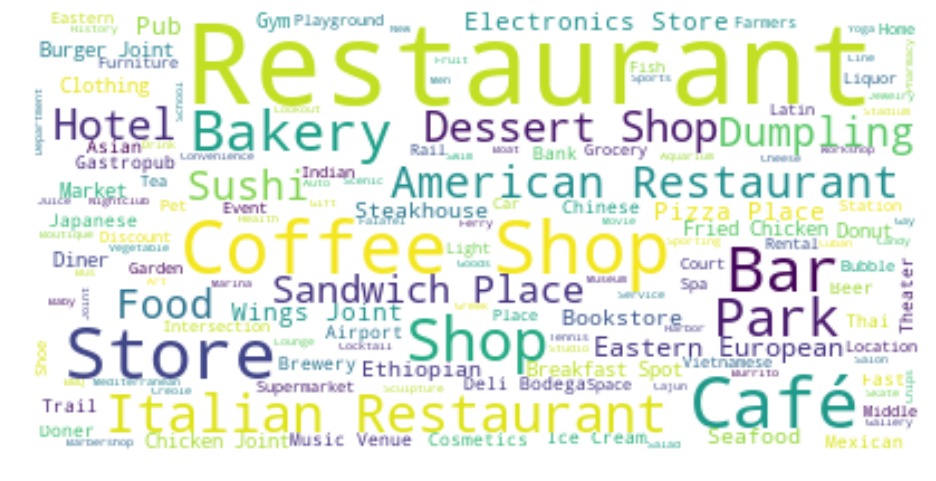

In [368]:
# generating word cloud for toronto data.
toronto_venues = []
cols = ["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue","6th Most Common Venue","7th Most Common Venue","8th Most Common Venue","9th Most Common Venue","10th Most Common Venue"]
tmp1 =toronto_merged[["1st Most Common Venue","2nd Most Common Venue","3rd Most Common Venue","4th Most Common Venue","5th Most Common Venue","6th Most Common Venue","7th Most Common Venue","8th Most Common Venue","9th Most Common Venue","10th Most Common Venue"]]

for i in cols:
    toronto_venues.append(tmp1[i].str.cat(sep=' '))

toronto_venues = ' '.join(map(str,toronto_venues)) 
generate_word_cloud(toronto_venues)

In [369]:
# getting the latitide and longitude of Toronto
address = 'Central Toronto,Toronto'

geolocator = Nominatim(user_agent="tn_explorer")
location = geolocator.geocode(address)
toronto_latitude = location.latitude
toronto_longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(toronto_latitude, toronto_longitude))

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [370]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

toronto_json = r'C:/Users/akhil/Downloads/simple.geojson'
folium.GeoJson(toronto_json).add_to(map_clusters)


# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(' Cluster ' + str(cluster + 1) + str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##  Examine London city Clusters


#### Cluster 1

just making a seprate data frames for each cluster which will help us in further analysis

In [371]:
clus1 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus1.head()

Borough  Cluster Labels 1st Most Common Venue  \
0     East Toronto               0     Health Food Store   
9  Central Toronto               0           Coffee Shop   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0                 Trail                   Pub           Wings Joint   
9                   Pub    Light Rail Station   American Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0          Dessert Shop           Event Space  Ethiopian Restaurant   
9           Supermarket      Sushi Restaurant          Liquor Store   

  8th Most Common Venue        9th Most Common Venue 10th Most Common Venue  
0     Electronics Store  Eastern European Restaurant    Dumpling Restaurant  
9            Sports Bar          Fried Chicken Joint             Restaurant

In [372]:
# for popups in map assigning the lists
df_tmp_clus1 = pd.DataFrame(clus1.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus1.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus1.loc[df_tmp_clus1.boroughs == "Central Toronto","top_venues"].values

array(['Coffee Shop'], dtype=object)

From above groupby we can see that cluster 1 has many coffeshops and is the busiest as it is downtown of toronto.

#### Cluster 2


In [373]:
clus2 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus2.head()

Borough  Cluster Labels 1st Most Common Venue  \
10  Downtown Toronto               1                  Park   
23   Central Toronto               1                  Park   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
10            Playground                 Trail           Wings Joint   
23                 Trail         Jewelry Store      Sushi Restaurant   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
10      Department Store  Ethiopian Restaurant     Electronics Store   
23           Wings Joint          Dessert Shop  Ethiopian Restaurant   

          8th Most Common Venue        9th Most Common Venue  \
10  Eastern European Restaurant          Dumpling Restaurant   
23            Electronics Store  Eastern European Restaurant   

   10th Most Common Venue  
10             Donut Shop  
23    Dumpling Restaurant

In [374]:
# for popups in map assigning the lists
df_tmp_clus2 = pd.DataFrame(clus2.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus2.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus2.loc[df_tmp_clus2.boroughs == "Central Toronto","top_venues"].values

array(['Park'], dtype=object)

we can observe that cluster2 has just 2 points one from central and one from downtown toronto and is more focused on parks and play grounds. 

#### Cluster 3


In [375]:
clus3 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus3.head()

Borough  Cluster Labels 1st Most Common Venue  \
1     East Toronto               2      Greek Restaurant   
2     East Toronto               2                  Park   
3     East Toronto               2                  Café   
5  Central Toronto               2      Asian Restaurant   
6  Central Toronto               2        Clothing Store   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1           Coffee Shop        Ice Cream Shop    Italian Restaurant   
2           Pizza Place             Pet Store         Movie Theater   
3           Coffee Shop                Bakery    Italian Restaurant   
5                  Park                   Gym        Sandwich Place   
6           Coffee Shop   Sporting Goods Shop            Shoe Store   

  5th Most Common Venue 6th Most Common Venue   7th Most Common Venue  \
1            Restaurant             Bookstore  Furniture / Home Store   
2      Sushi Restaurant    Italian Restaurant       Fish & Chips Shop   
3   American Restaurant             Bookstore       Convenience Store   
5        Breakfast Spot        Clothing Store       Food & Drink Shop   
6          Burger Joint    Salon / Barbershop              Restaurant   

       8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
1    Fruit & Vegetable Store     Indian Restaurant              Juice Bar  
2             Ice Cream Shop  Fast Food Restaurant                    Pub  
3  Latin American Restaurant           Fish Market         Sandwich Place  
5                      Hotel      Doner Restaurant         Discount Store  
6        Rental Car Location    Chinese Restaurant            Yoga Studio

In [376]:
# for popups in map assigning the lists
df_tmp_clus3 = pd.DataFrame(clus3.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus3.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus3.loc[df_tmp_clus3.boroughs == "Central Toronto","top_venues"].values

array(['Asian Restaurant,Clothing Store,Dessert Shop,Intersection,Sandwich Place'],
      dtype=object)

Cluster 3 has gardens and seems great chillout neighbourhood.

#### Cluster 4


In [377]:
clus4 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
clus4.head()

Borough  Cluster Labels 1st Most Common Venue  \
4  Central Toronto               3                  Park   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4           Swim School              Bus Line           Wings Joint   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4          Dessert Shop  Ethiopian Restaurant     Electronics Store   

         8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
4  Eastern European Restaurant   Dumpling Restaurant             Donut Shop

In [378]:
# for popups in map assigning the lists
df_tmp_clus4 = pd.DataFrame(clus4.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus4.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus4.loc[df_tmp_clus4.boroughs == "Central Toronto","top_venues"].values

array(['Park'], dtype=object)

Cluster 4 is all about shopping and public transport relatable right?

#### Cluster 5


In [379]:
clus5 = toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, london_merged.shape[1]))]]
clus5.head()

Borough  Cluster Labels 1st Most Common Venue  \
22  Central Toronto               4                Garden   

   2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
22           Wings Joint          Dessert Shop           Event Space   

   5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
22  Ethiopian Restaurant     Electronics Store  Eastern European Restaurant   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
22   Dumpling Restaurant            Donut Shop       Doner Restaurant

In [380]:
# for popups in map assigning the lists
df_tmp_clus5 = pd.DataFrame(clus5.groupby("Borough")["1st Most Common Venue"].apply(lambda x: ','.join(x.unique())).reset_index())
df_tmp_clus5.rename(columns={'Borough':'boroughs', '1st Most Common Venue': 'top_venues'},inplace=True)
df_tmp_clus5.loc[df_tmp_clus5.boroughs == "Central Toronto","top_venues"].values

array(['Garden'], dtype=object)

Cluster 5 is mix restaurants and stores also, we have public transit more focused here.

In [381]:
# create map
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12.2)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

toronto_json = r'C:/Users/akhil/Downloads/simple.geojson'
folium.GeoJson(toronto_json).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, top_spot, borough  in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels'],
                                 toronto_merged['1st Most Common Venue'], toronto_merged['Borough']):
    # putting the extra options to explore in each cluster on the popups 
    if cluster == 0: 
        label = folium.Popup("<h6> <center>Coffee House </center></h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus1.loc[df_tmp_clus1.boroughs == borough,"top_venues"].values)),parse_html=False)
    elif cluster == 1:
        label = folium.Popup("<center>Parks and Playgrounds </center>\
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus2.loc[df_tmp_clus2.boroughs == borough,"top_venues"].values)),parse_html=False)
    
        
    elif cluster == 2:
        label = folium.Popup("<h6> <center>Gardens </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus3.loc[df_tmp_clus3.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    elif cluster == 3:
        label = folium.Popup("<h6> <center> Shoping and Restaurants </center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus4.loc[df_tmp_clus4.boroughs == borough,"top_venues"].values)),parse_html=False)
    
    elif cluster == 4:
        label = folium.Popup("<h6> <center>Stores and transport</center> </h6> \
                             <h6><b> {}</b> : {}</h6> \
                          <h6> <b> {} </b> : {} </h6> ".format(str(poi),str(top_spot),str(borough),str(df_tmp_clus5.loc[df_tmp_clus5.boroughs == borough,"top_venues"].values)),parse_html=False)
        
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

##### From map we can see that our neighborhoods analysis shows the results in popup with trending venues from foursquare api. which lets us know which is first and foremost place to go will be the one whcich is famous in neighborhood and other things trending in that Borough are mentioned below the line. 


# Results
The following are the highlights of the 5 clusters above:

#### we have sucesfully analysed neighborhoods in toronto which let us know which are the places to go for coffee in downtwon or where to go for some relaxation( like cluster 3 having parks and playgrounds ).
if some one is looking to buy a house on toronto then we can se we have 5 options 
1. if he wants all the resources and office near home he can buy house in cluser 1.
2. if he wants rexalxed non busy envoirnment then he should go for 2nd cluster area.
3. if he wants gardens nearby go for cluster 3 (East or central Toronto).
4. if he wants more of public transport as well as shopping and stores nearby home he should go for Central Toronto(4/5 clusters).

These sugessions can be further broken down as per boroughs.

# Compararing the Neighborhoods of both Toronto and London
We can say that both the cities have most of the popular venues in downtown/ financial district as one of the the cluster is much larger than others. Coffee Shops and Restaurants are the most popular among both the cities. Also, most importantly Italian Restaurants are popular in both the cities. 
If we had access to Fursqare Api premium calls we could have got insights about age grouos checkins in venues like in pubs mostly young age group whould have checkins while for restaurants and parks we whould have middle age group checkins.

In conclusion, this project would have had better results if there were more data in terms of crime data within the area, traffic access and allowance of more venues exploration with the Foursquare (limited venues for free calls).
Also, getting the ratings and feedback of the current restaurants within the clusters would have helped in providing more insight into the best location.
